## Next Reaction method simulation for 2D root development

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
%matplotlib notebook

In [2]:
# giu' su sinistra destra
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [0,8,0,0], [0,8,0,0] 
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [8,0,0,12], [8,0,12,0]
vascular = [8,0,0,0]


P_out = np.zeros((22,12,4))

# 22 rows, 12 columns. The first is the upmost cell in the tip

# cinta esterna della radice (muraria)
P_out[0,:,:]=[0,0,0,0]
# this cells can only pass auxin to vascular and border
P_out[-1,:,:]=[8,0,0,0]
P_out[:,0,:]=[0,0,0,0]
P_out[:,-1,:]=[0,0,0,0]

# in futuro aggiungeremo un flusso di auxina dallo shoot

# defining colummellas
P_out[1:4,1:11] = colummella

# defining epidermal
P_out[4:21,1:3] = epidermal_l
P_out[4:21,9:11] = epidermal_r

# defining border
P_out[4:21,3] = border_l
P_out[4:21,8] = border_r

# defining vascular
P_out[4:21,4:8] = vascular

# defining QC in position [4,4:8] same PIN settings as vascular


In [3]:
D=1.4
T=0.6

In [42]:
def update_2D(cells,t, dt, source=(0,0), source_val=10, D=D, T=T, P_out=P_out, decay=0.000005, upper_bound=5000):
    """
    updates vector of cells following equation (1)

    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[1,0], [-1,0], [0,-1], [0,1]])
    updated_cells = cells
    cells_flux = np.zeros((2,len(cells),12))
    
    initial_concentrations = sum(sum(cells))
    qc = 0
    step_tot=0
    
    for i, value in enumerate(cells[1:21], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k]/96 for k in tuple(map(tuple, v + [i,j]))]
            
            auxin_square = value[j]/96
            #aux_decay = -decay*value[j]            
            D_out = D*(1/20)
            
            #apoplast
            apoplast_down_neighbour =  [neighbours[0]*8*D_out if P_out[i-1,j,1]==0 else T*P_out[i-1,j,1]*neighbours[0]*8][0]
            apoplast_down_me = [auxin_square*8*D_out if P_out[i,j,0]==0 else T*P_out[i,j,0]*auxin_square*8][0]
            apoplast_down = apoplast_down_neighbour + apoplast_down_me
    
            apoplast_up_neighbour =  [neighbours[1]*8*D_out if P_out[i+1,j,0]==0 else T*P_out[i+1,j,0]*neighbours[1]*8][0]
            apoplast_up_me = [auxin_square*8*D_out if P_out[i,j,1]==0 else T*P_out[i,j,1]*auxin_square*8][0]
            apoplast_up = apoplast_up_neighbour + apoplast_up_me
    
            apoplast_left_neighbour = [neighbours[2]*12*D_out if  P_out[i, j-1, 3]==0 else T*P_out[i, j-1, 3]*neighbours[2]*12][0]
            apoplast_left_me = [auxin_square*8*D_out if P_out[i,j,2]==0 else T*P_out[i,j,2]*auxin_square*12][0]
            apoplast_left = apoplast_left_neighbour + apoplast_left_me
    
            apoplast_right_neighbour = [neighbours[3]*12*D_out if P_out[i, j+1, 2]==0 else T*P_out[i, j+1, 2]*neighbours[3]*12][0]
            apoplast_right_me = [auxin_square*12*D_out if P_out[i,j,3]==0 else T*P_out[i,j,3]*auxin_square*12][0]
            apoplast_right = apoplast_right_neighbour + apoplast_right_me
            
            # diffusion in
            diffusion_in_down= D*apoplast_down
            diffusion_in_up= D*apoplast_up
            diffusion_in_left= D*apoplast_left
            diffusion_in_right= D*apoplast_right
            diffusion_in_total = diffusion_in_down + diffusion_in_left + diffusion_in_right + diffusion_in_up
            
            # transport out: don't give to neighbou if he exceeds the upper bound
            transport_out_down = -T*P_out[i,j,0]*auxin_square*8
            transport_out_up =  -T*P_out[i,j,1]*auxin_square*8
            transport_out_left =  -T*P_out[i,j,2]*auxin_square*12
            transport_out_right = -T*P_out[i,j,3]*auxin_square*12
            transport_out_total = transport_out_down + transport_out_left + transport_out_right + transport_out_up
            
            # diffusion_out = -(1/20)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]
            diffusion_out_down = [auxin_square*8*(-D_out) if P_out[i,j,0] == 0 else 0][0]
            diffusion_out_up = [auxin_square*8*(-D_out) if P_out[i,j,1] == 0 else 0][0]
            diffusion_out_left = [auxin_square*12*(-D_out) if P_out[i,j,2] == 0 else 0][0]
            diffusion_out_right = [auxin_square*12*(-D_out) if P_out[i,j,3] == 0 else 0][0]
                
                
            # these are the cases in which the cell is at an extremity: we don't have diffusion outside of the root itself
            if i == 1:
                diffusion_out_down, transport_out_down = 0,0
            if j==1:
                diffusion_out_left, transport_out_left = 0,0
            if j==10:
                diffision_out_right, diffusion_out_right = 0,0
            
            diffusion_out_total = diffusion_out_down + diffusion_out_left + diffusion_out_right + diffusion_out_up 
            
            x_coord = (abs(transport_out_left)-abs(transport_out_right))
            y_coord = (abs(transport_out_up)-abs(transport_out_down))
            step_direction_flux[:,j] = (x_coord, y_coord)
              
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = transport_out_total + diffusion_out_total + diffusion_in_total
            if step[j] <= 0:
                step[j] = 8*12*0.0005*4
            step_tot += step[j]
            
#             step[j] = value[j] + step[j]     
             
            if i==3 and j==5:
                qc+=step[j]
                
        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
    
    
#     updated_cells[source[0], source[1]:source[1]+4] += source_val*8*12*dt
    
    #print(initial_concentrations, sum(sum(updated_cells)), step_tot+source_val*8*12*4)
    return updated_cells

<IPython.core.display.Javascript object>


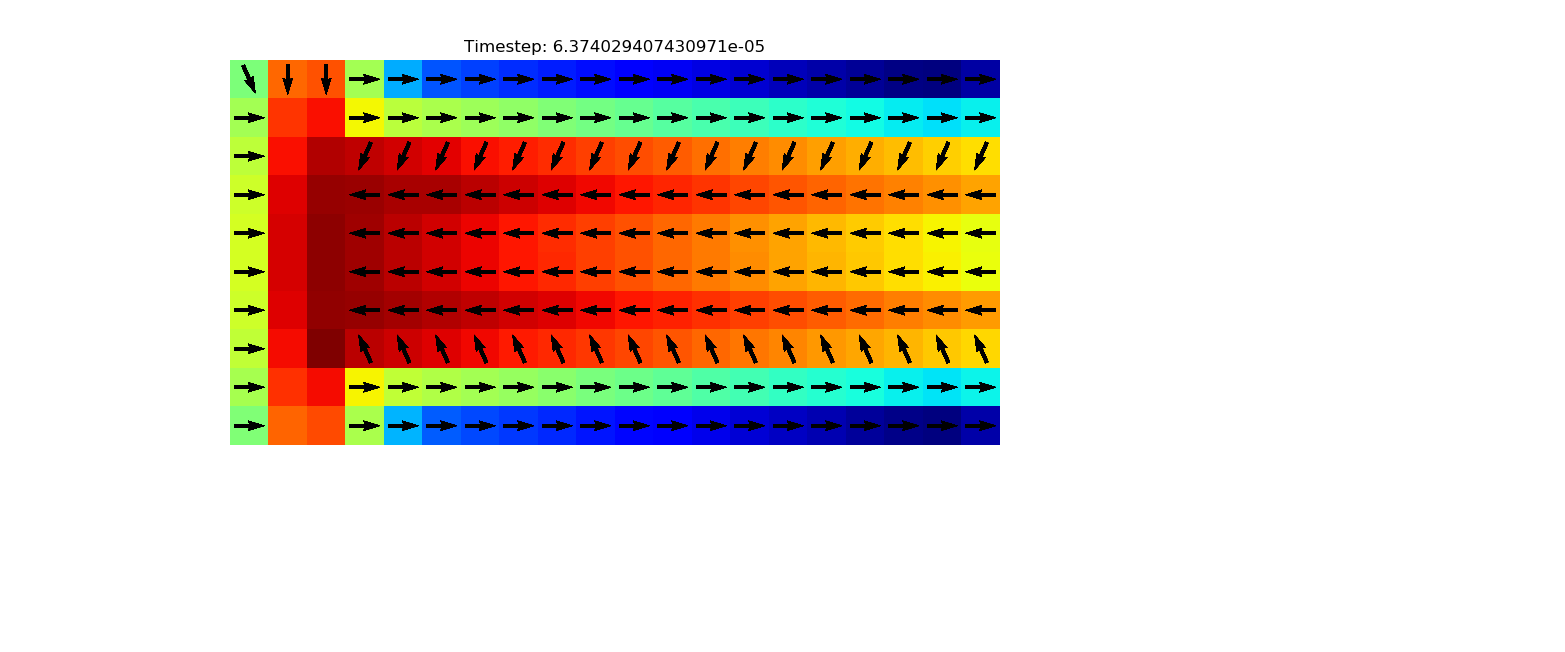

/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [43]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1, 3:9]=70
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
# cells_a[4,4:8] = 0
fig= plt.figure(figsize=(12,5)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a[1:-1,1:-1].T, cmap="jet")
cells_out = cells_a

T = []
t = 0
sim_time=0.0001
while t<sim_time:
    cells_prev=cells_out    #need to keep track of the previous state
    cells_out, cells_fluxes, qc = update_2D(cells_out, dt=0.5, T=0.6, D=1.4)
    #auxin production and decay happe independently from the reaction that is fired: apply them to all cells
    for cell_row in cells_out:
        for cell in cell_row:
            cell+=  8*12*0.0005*4 - cell*0.000005    #production - degradation of auxin
    
    ## NRM
    z1 = np.random.uniform(0,1)
    acum = np.cumsum(cells_out)
    atot = acum[-1] 
    tau = -np.log(z1)/np.sum(cells_out)
    z2 = np.random.uniform(0,1)
    zatot = z2*atot
    mu = np.where(acum>zatot)[0][0]
    cells_prev[mu//12][mu%12] = cells_prev[mu//12][mu%12] + cells_out[mu//12][mu%12] #only one cell will be updated
    cells_out=cells_prev
    t = t + tau
    T.append(t)
    
    plt.imshow(np.log10(cells_out[1:-1,1:-1].T), cmap="jet")
#     U = cells_fluxes[1,1:-1,1:-1].T
#     V = cells_fluxes[0,1:-1,1:-1].T
#     U_norm = U / np.sqrt(U**2 + V**2)
#     V_norm = V / np.sqrt(U**2 + V**2)
    
#     plt.quiver(U_norm, V_norm, pivot='mid')

    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t>sim_time:
#         plt.clf() to avoid the clearance of the plot
        pass

In [31]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1, 3:9]=70
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
# cells_a[4,4:8] = 0
fig= plt.figure(figsize=(12,5)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a[1:-1,1:-1].T, cmap="jet")
cells_out = cells_a

T = []
t = 0
sim_time=0.0001
    
plt.imshow(np.log10(cells_out[1:-1,1:-1].T), cmap="jet")
#     U = cells_fluxes[1,1:-1,1:-1].T
#     V = cells_fluxes[0,1:-1,1:-1].T
#     U_norm = U / np.sqrt(U**2 + V**2)
#     V_norm = V / np.sqrt(U**2 + V**2)
    
#     plt.quiver(U_norm, V_norm, pivot='mid')

    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t>sim_time:
#         plt.clf() to avoid the clearance of the plot
        pass

(21, 12)

In [4]:
def RK4(f):
    return lambda t, y, root, dt: (
            lambda dy1: (
            lambda dy2: (
            lambda dy3: (
            lambda dy4: (dy1 + 2*dy2 + 2*dy3 + dy4)/6
            )( dt * f( t + dt  , y + dy3   , root) )
	    )( dt * f( t + dt/2, y + dy2/2 , root) )
	    )( dt * f( t + dt/2, y + dy1/2 , root) )
	    )( dt * f( t       , y         , root) )

def update_cell(t, y, root, D,T,P)

from math import sqrt
dy = RK4(update_cell)

dy(t, cell, dt)

In [24]:
def update_2_cells(cells, D=0.3, T=0.2):
    """
    function that takes the initial condition of a two-cells system
    that communicate through passive diffusion and active transport
    as input.
    
    returns a d[cells]/dt
    
    """
    
    d_cells = np.zeros(cells.shape)
    # define changes of concetration within each cell
    # change-rate = diffusion in - diffusion out + transport in - transport out
    d_cells[0] = D*(cells[1] - cells[0]) + T*(8*cells[1] - 12*cells[0])
    d_cells[1] = D*(cells[0] - cells[1]) + T*(12*cells[0] - 8*cells[1])
    
    return d_cells

def update_3_cells(cells, D=0.3, T=0.2):
    """
    function that takes the initial condition of a three-cells system
    that communicate through passive diffusion and active transport
    as input.
    
    returns a d[cells]/dt
    
    """
    
    d_cells = np.zeros(cells.shape)
    # define changes of concetration within each cell
    # change-rate = diffusion in - diffusion out + transport in - transport out
    d_cells[0] = D*(cells[1] - cells[0]) + T*(8*cells[1] - cells[0])
    # change-rate = diffusion_in_left - diffusion_out_left + diffusion_in_right - diffusion_out_right 
    #    + transport_in_left - transport_out_left + transport_in_right - transport_out_right
    d_cells[1] = D*(cells[0] - 2*cells[1] + cells[2]) + T*(cells[0] - 2*8*cells[1] + cells[2])
    
    d_cells[2] = D*(cells[1] - cells[2]) + T*(8*cells[1] - cells[2])
    return d_cells

In [25]:
# total: 175 (per cell ~ 58.3 on convergence)
cells = np.array([100, 0, 0])
print(cells.shape)

timeline = []
for t in np.arange(0,20,0.01):
    cells_step = 0.01*update_3_cells(cells)
    cells = np.add(cells, cells_step)
    timeline.append(cells)

(3,)


In [59]:
def update_n_cells(cells, pins, D=0.3, T=0.2):
    d_cells = np.zeros(cells.shape)
    for i in range(len(cells)):
        if i == 0:
            # extreme left
            d_cells[i] = D*(cells[1] - cells[0]) + T*(pins[i+1,0]*cells[1] - (pins[i,0]*cells[0] + pins[i,1]*cells[0]))
        elif i == len(cells)-1:
            # extreme right
            d_cells[i] =  D*(cells[-2] - cells[-1]) + T*(pins[-2,1]*cells[-2] - (pins[-1,0]*cells[-1] + pins[-1,1]*cells[-1]))
        else:
            # all other cells
            d_cells[i] = D*(cells[i-1] -2*cells[i] + cells[i+1]) +T*(pins[i-1,1]*cells[i-1] 
                                                                     - (pins[i,0]*cells[i]+pins[i,1]*cells[i]) 
                                                                     + pins[i+1,0]*cells[i+1])
    return d_cells

(6,)


<IPython.core.display.Javascript object>


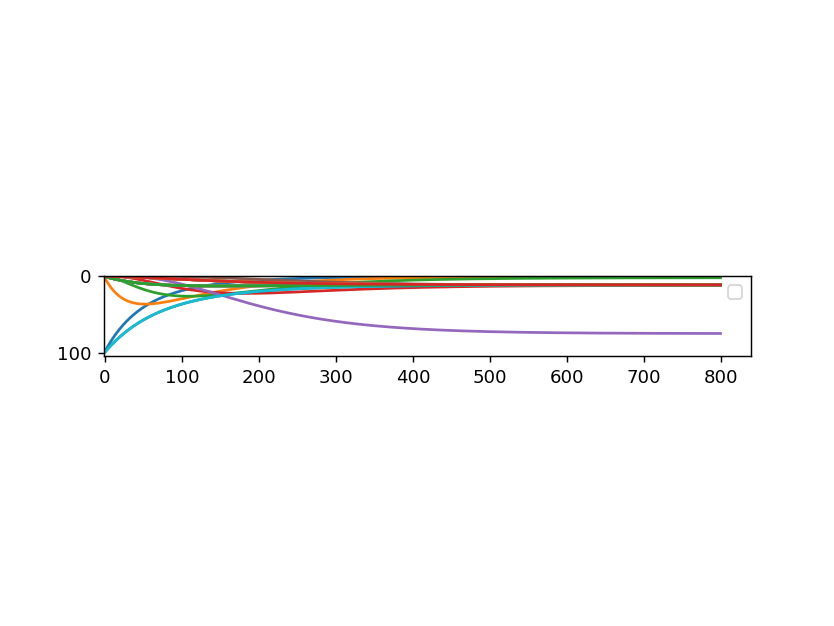

In [66]:
# total: 175 (per cell ~ 58.3 on convergence)
cells = np.array([100,0,0,0,0,0])

pins=np.array([[0,0,0,0,0,8],
      [8,8,8,8,0,0]])
print(cells.shape)

timeline = []
for t in np.arange(0,8,0.01):
    cells_step = 0.01*update_n_cells(cells,pins.T)
    cells = np.add(cells, cells_step)
    timeline.append(cells)

plt.plot(timeline)
plt.legend(["cell1", "cell2", "cell3","cell4","cell5","cell6"])

In [32]:
timeline

[array([ 99.5,   0.5,   0. ,   0. ,   0. , 100. ]),
 array([9.9012e+01, 9.7850e-01, 9.5000e-03, 0.0000e+00, 0.0000e+00,
        1.0000e+02]),
 array([9.85355315e+01, 1.43642450e+00, 2.80440000e-02, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+02]),
 array([9.80701459e+01, 1.87465825e+00, 5.51958455e-02, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+02]),
 array([9.76154137e+01, 2.29404794e+00, 9.05383730e-02, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+02]),
 array([ 97.17092353,   2.69540388,   0.13367259,   0.        ,
          0.        , 100.        ]),
 array([ 96.73628158,   3.07950151,   0.1842169 ,   0.        ,
          0.        , 100.        ]),
 array([ 96.3111107 ,   3.44708295,   0.24180635,   0.        ,
          0.        , 100.        ]),
 array([ 95.89504973,   3.79885838,   0.30609189,   0.        ,
          0.        , 100.        ]),
 array([ 95.48775279,   4.13550747,   0.37673974,   0.        ,
          0.        , 100.        ]),
 array

In [170]:
def update_grid_cells(cells, pins, D=0.3, T=0.2):
    
    """
    pins = [i,j,direction]
    direction index = [up,down,left,right]
    """
    
    d_cells = np.zeros(cells.shape)
    
    for i in range(cells.shape[0]):
        for j in range(cells.shape[1]):
            # check for spatial limits to evaluate diffusion 
            if i == 0 or i == cells.shape[0]-1:
                # first or last row of the grid
                if j == 0 or j == cells.shape[1]-1:
                    # top-left, top-right, bottom-left, bottom-right corner cells
                    if i == 0 and j == 0:
                        # top-left = D*(down_cell + right_cell - 2*self_cell) + T*(pins_up*down_cell + pins_left*right_cell 
                        #                                                          - pins_down*self_cell -pins_right*self_cell)
                        d_cells[i,j] = D*(cells[i+1,j] + cells[i,j+1] - 2*cells[i,j]) 
                        + T*(pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,1]*cells[i,j+1] 
                             -cells[i,j]*(pins[i,j,1]+pins[i,j,3]))
                        
                    if i == 0 and j == cells.shape[1]-1:
                        # top-right = D*(left_cell + down_cell - 2*self_cell) + T*(pins_right*left_cell + pins_up*down_cell
                        #                                                          - self_cell*(pins_left + pins_down))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] - 2*cells[i,j]) 
                        + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]
                             -cells[i,j]*(pins[i,j,2] + pins[i,j,1]))
                        
                    if i == cells.shape[0]-1 and j == 0:
                        # bottom-left = D*(up_cell + right_cell - 2*self_cell) 
                        #               + T*(pins_left*rigth_cell + pins_down*up_cell
                        #                    - self_cell*(pins_right + pins_up))
                        d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] -2*cells[i,j]) 
                        + T*(pins[i,j+1,2]*cells[i,j+1] + pins[i-1,j,1]*cells[i-1,j] 
                             -cells[i,j]*(pins[i,j,3] + pins[i,j,0]))
                    if i == cells.shape[0]-1 and j == cells.shape[1]-1:
                        # bottom-right = D*(left_cell + up_cell - 2*self_cell) 
                        #                + T*(pins_right*left_cell + pins_down*up_cell
                        #                     - self_cell*(pins_left + pins_up))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] - 2*cells[i,j]) 
                        + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j] 
                             -cells[i,j]*(pins[i,j,2] + pins[i,j,0]))
                elif i == 0:
                    # non-corner cell on top row
                    # top-row-cell = D*(left_cell + down_cell + right cell - 3*self_cell) 
                    #                +T*(pins_right*left_cell + pins_up*down_cell + pins_left*right_cell
                    #                    - self_cell(pins_left + pins_down + pins_right))
                    
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] + cells[i,j+1] - 3*cells[i,j]) 
                    + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,2]*cells[i,j+1]
                        - cells[i,j]*(pins[i,j,2]+pins[i,j,1]+pins[i,j,3]))
                else:
                    # non-corner cell on bottom row
                    # bottom-row-cell = D*(left_cell + up_cell + right cell - 3*self_cell)
                    #                   + T*(pins_right*left_cell + pins_down*up_cell + pins_left*right_cell
                    #                        - self_cell*(pins_left + pins_up + pins_right))
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] + cells[i,j+1] - 3*cells[i,j]) 
                    + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1]
                        - cells[i,j]*(pins[i,j,2] + pins[i,j,0] + pins[i,j,3]))
            elif j == 0:
                # non-corner cases on leftmost column
                # left-row-cell = D*(up_cell + right_cell + down_cell - 3*self_cell) 
                #                 + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                      - self_cell*(pins_up + pins_right + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] + cells[i+1,j] - 3*cells[i,j])
                + T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1] + pins[i+1,j,0]*cells[i+1,j]
                    - cells[i,j]*(pins[i,j,0]+pins[i,j,3]+pins[i,j,1]))
            elif j == cells.shape[1]-1:
                # non-corner cases on rightmost column
                # right-row-cell = D*(up_cell + left_cell + down_cell - 3*self_cell) 
                #                  + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                       - self_cell*(pins_up + pins_left + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j-1] + cells[i+1,j] - 3*cells[i,j])
                + T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]
                    - cells[i,j]*(pins[i,j,0]+pins[i,j,2]+pins[i,j,1]))
            else:
                # central-cell = D*(up_cell + down_cell + left_cell + right_cell - 4*self_cell) 
                #               + T*(pins_down*up_cell + pins_up*down_cell + pins_right*left_cell + pins_left*right_cell
                #                 - self_cell*(pins_up + pins_down + pins_left+ pins_right))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i+1,j] + cells[i,j-1] + cells[i,j+1] - 4*cells[i,j])
                +T*(pins[i-1,j,1]*cells[i-1,j] + pins[i+1,j,0]*cells[i+1,j] 
                    + pins[i,j-1,3]*cells[i,j-1] + pins[i,j+1,2]*cells[i,j+1]
                   - cells[i,j]*(pins[i,j,0]+pins[i,j,1]+pins[i,j,2]+pins[i,j,3]))
    return d_cells

In [174]:
timeline = []
for t in np.arange(0,20,0.01):
    cells_step = 0.01*update_grid_cells(cells,pins)
    cells = np.add(cells, cells_step)
    timeline.append(cells)

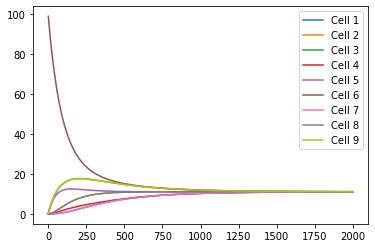

In [175]:
%matplotlib inline
timeline = np.array(timeline)
plt.plot(timeline.reshape(timeline.shape[0], 9))
plt.legend(["Cell 1","Cell 2","Cell 3","Cell 4","Cell 5","Cell 6","Cell 7","Cell 8","Cell 9"])

In [182]:
cells = np.array([[0,0,0],[0,0,100],[0,0,0]])
pins = np.zeros((3,3,4))

<IPython.core.display.Javascript object>


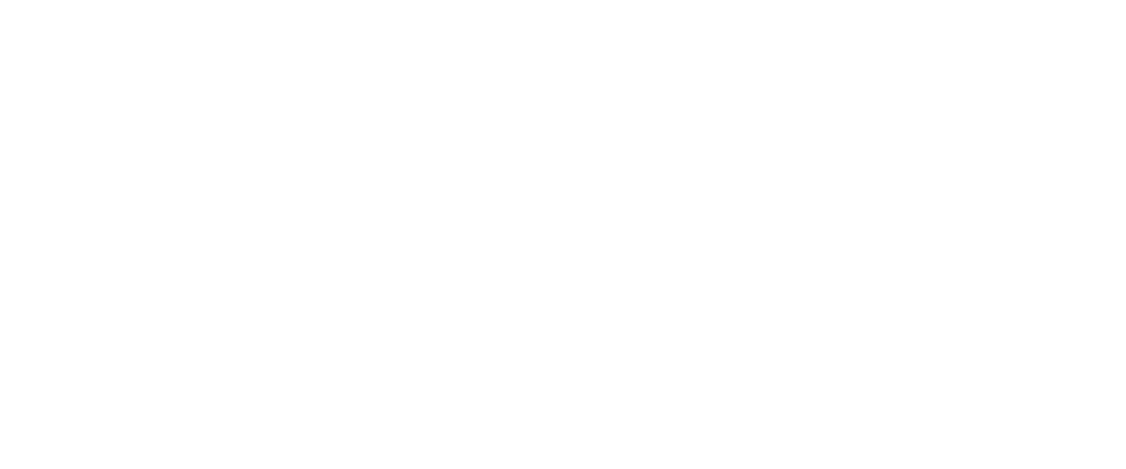

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


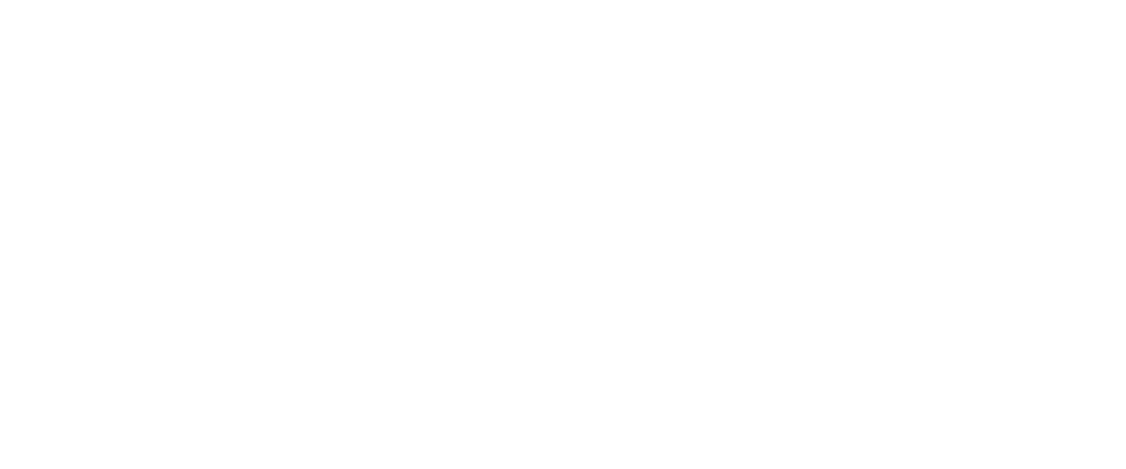

In [183]:
%matplotlib notebook
fig= plt.figure(figsize=(12,5)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')

timeline = []
dt = 0.01
for t in np.arange(0,20,dt):
    cells_step = dt*update_grid_cells(cells,pins,T=0)
    cells = np.add(cells, cells_step)
    timeline.append(cells)
    plt.imshow(cells, cmap="jet")
    plt.title(f"Timestep: {str(t)}")
    fig.canvas.draw()
    fig.canvas.flush_events()
    

In [4]:
import pixiedust

Pixiedust database opened successfully


In [ ]:
%%pixie_debugger
## Test with central QC

def update_grid_cells(cells, pins, D=0.3, T=0.2):
    
    """
    pins = [i,j,direction]
    direction index = [up,down,left,right]
    """
    
    d_cells = np.zeros(cells.shape)
    
    for i in range(cells.shape[0]):
        for j in range(cells.shape[1]):
            value = cells[i,j]
            # check for spatial limits to evaluate diffusion 
            if i == 0 or i == cells.shape[0]-1:
                # first or last row of the grid
                if j == 0 or j == cells.shape[1]-1:
                    # top-left, top-right, bottom-left, bottom-right corner cells
                    if i == 0 and j == 0:
                        # top-left = D*(down_cell + right_cell - 2*self_cell) + T*(pins_up*down_cell + pins_left*right_cell 
                        #                                                          - pins_down*self_cell -pins_right*self_cell)
                        d_cells[i,j] = D*(cells[i+1,j] + cells[i,j+1] - 2*cells[i,j]) 
                        + T*(pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,1]*cells[i,j+1] -cells[i,j]*(pins[i,j,1]+pins[i,j,3]))
                        
                    if i == 0 and j == cells.shape[1]-1:
                        # top-right = D*(left_cell + down_cell - 2*self_cell) + T*(pins_right*left_cell + pins_up*down_cell
                        #                                                          - self_cell*(pins_left + pins_down))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] - 2*cells[i,j]) 
                        + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]-cells[i,j]*(pins[i,j,2] + pins[i,j,1]))
                        
                    if i == cells.shape[0]-1 and j == 0:
                        # bottom-left = D*(up_cell + right_cell - 2*self_cell) 
                        #               + T*(pins_left*rigth_cell + pins_down*up_cell
                        #                    - self_cell*(pins_right + pins_up))
                        d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] -2*cells[i,j]) 
                        + T*(pins[i,j+1,2]*cells[i,j+1] + pins[i-1,j,1]*cells[i-1,j]-cells[i,j]*(pins[i,j,3] + pins[i,j,0]))
                    if i == cells.shape[0]-1 and j == cells.shape[1]-1:
                        # bottom-right = D*(left_cell + up_cell - 2*self_cell) 
                        #                + T*(pins_right*left_cell + pins_down*up_cell
                        #                     - self_cell*(pins_left + pins_up))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] - 2*cells[i,j]) 
                        + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j]-cells[i,j]*(pins[i,j,2] + pins[i,j,0]))
                elif i == 0:
                    # non-corner cell on top row
                    # top-row-cell = D*(left_cell + down_cell + right cell - 3*self_cell) 
                    #                +T*(pins_right*left_cell + pins_up*down_cell + pins_left*right_cell
                    #                    - self_cell(pins_left + pins_down + pins_right))
                    
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] + cells[i,j+1] - 3*cells[i,j]) 
                    + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,2]+pins[i,j,1]+pins[i,j,3]))
                else:
                    # non-corner cell on bottom row
                    # bottom-row-cell = D*(left_cell + up_cell + right cell - 3*self_cell)
                    #                   + T*(pins_right*left_cell + pins_down*up_cell + pins_left*right_cell
                    #                        - self_cell*(pins_left + pins_up + pins_right))
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] + cells[i,j+1] - 3*cells[i,j]) 
                    + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,2] + pins[i,j,0] + pins[i,j,3]))
            elif j == 0:
                # non-corner cases on leftmost column
                # left-row-cell = D*(up_cell + right_cell + down_cell - 3*self_cell) 
                #                 + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                      - self_cell*(pins_up + pins_right + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] + cells[i+1,j] - 3*cells[i,j])
                + T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1] + pins[i+1,j,0]*cells[i+1,j]- cells[i,j]*(pins[i,j,0]+pins[i,j,3]+pins[i,j,1]))
            elif j == cells.shape[1]-1:
                # non-corner cases on rightmost column
                # right-row-cell = D*(up_cell + left_cell + down_cell - 3*self_cell) 
                #                  + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                       - self_cell*(pins_up + pins_left + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j-1] + cells[i+1,j] - 3*cells[i,j])
                + T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]- cells[i,j]*(pins[i,j,0]+pins[i,j,2]+pins[i,j,1]))
            else:
                # central-cell = D*(up_cell + down_cell + left_cell + right_cell - 4*self_cell) 
                #               + T*(pins_down*up_cell + pins_up*down_cell + pins_right*left_cell + pins_left*right_cell
                #                 - self_cell*(pins_up + pins_down + pins_left+ pins_right))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i+1,j] + cells[i,j-1] + cells[i,j+1] - 4*cells[i,j])
                +T*(pins[i-1,j,1]*cells[i-1,j] + pins[i+1,j,0]*cells[i+1,j] 
                    + pins[i,j-1,3]*cells[i,j-1] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,0]+pins[i,j,1]+pins[i,j,2]+pins[i,j,3]))
    return d_cells

pins = np.zeros((3,3,4))
pins[0,1,1] = 8
pins[1,0,3] = 8
pins[2,1,0] = 8
pins[1,2,2] = 8

cells = np.array([[0,0,0],[0,0,100],[0,0,0]])

# %matplotlib notebook
# fig= plt.figure(figsize=(12,5)) #common canvas for any figure
# plt.ion()
# plt.title('Time: Beginning')
# plt.axis('off')

timeline = []
dt = 0.1
for t in np.arange(0,20,dt):
    cells_step = dt*update_grid_cells(cells,pins,D=0,T=0.5)
    cells = np.add(cells, cells_step)
    timeline.append(cells)
#     plt.imshow(cells, cmap="jet")
#     plt.title(f"Timestep: {str(t)}")
#     fig.canvas.draw()
#     fig.canvas.flush_events()


In [11]:
pins

array([[[0., 0., 0., 0.],
        [0., 8., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 8.],
        [0., 0., 0., 0.],
        [0., 0., 8., 0.]],

       [[0., 0., 0., 0.],
        [8., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [12]:
timeline

[array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[  0., 100.,   0.],
        [  0.,   0.,   0.]